In [1]:
import sys
sys.path.append("../../src")

import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from utils.kernel_utils import ColumnwiseRBF, RBF
from causal_models.proxy_causal_learning import KernelNegativeControlATE
from utils.ml_utils import data_transform
from generate_experiment_data import read_deaner_dataset

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
data_path = '../../data/deaner'
id_ = "IR"
seed = 100

W, Z, A, Y, do_A, EY_do_A = read_deaner_dataset(data_path, id_, seed)

W, Z, A, Y, do_A, EY_do_A = jnp.array(W), jnp.array(Z), jnp.array(A), jnp.array(Y), jnp.array(do_A), jnp.array(EY_do_A)

A_transformed, A_transformer = data_transform(A)
Z_transformed, Z_transformer = data_transform(Z)
W_transformed, W_transformer = data_transform(W)
Y_transformed, Y_transformer = data_transform(Y)

data_size = A_transformed.shape[0]
A_transformed = jnp.array(A_transformed).reshape(data_size, -1)
Z_transformed = jnp.array(Z_transformed).reshape(data_size, -1)
W_transformed = jnp.array(W_transformed).reshape(data_size, -1)
Y_transformed = jnp.array(Y_transformed).reshape(data_size, -1)

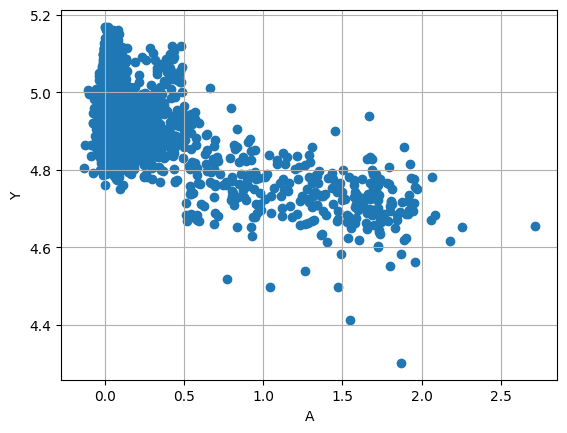

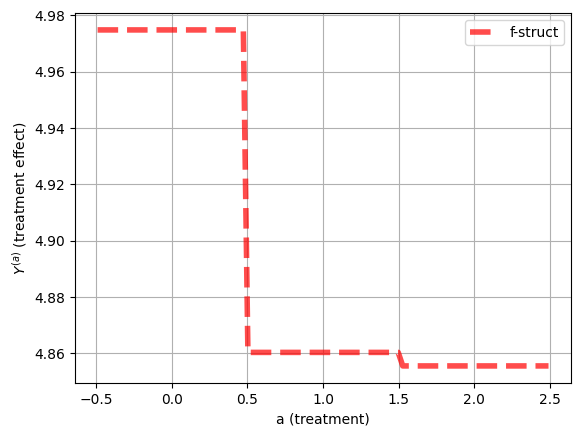

In [4]:
plt.scatter(A, Y)
plt.xlabel("A")
plt.ylabel("Y")
plt.grid()
plt.show()


plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha=0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()

In [5]:
RBF_Kernel_Z = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_W = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_A = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)
RBF_Kernel_X = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)

lambda_ = 0.1
zeta = 1*1e-4
optimize_regularization_parameters = True
lambda_optimization_range = (1e-15, 1.0)
stage1_perc = 0.5
regularization_grid_points = 150

model = KernelNegativeControlATE(
                                 kernel_A = RBF_Kernel_A,
                                 kernel_W = RBF_Kernel_W,
                                 kernel_Z = RBF_Kernel_Z,
                                 kernel_X = RBF_Kernel_X,
                                 lambda_ = lambda_,
                                 zeta = zeta, 
                                 optimize_regularization_parameters = True,
                                 lambda_optimization_range = (1e-9, 1.0),
                                 zeta_optimization_range = (1e-9, 1.0),
                                 large_lambda_zeta_option = True,
                                 selecting_biggest_lambda_tol = 5e-10,
                                 selecting_biggest_zeta_tol = 5e-3,
                                )

Structured function test set MSE: 0.0022346134278325605
Structured function test set MAE: 0.03380078966154557


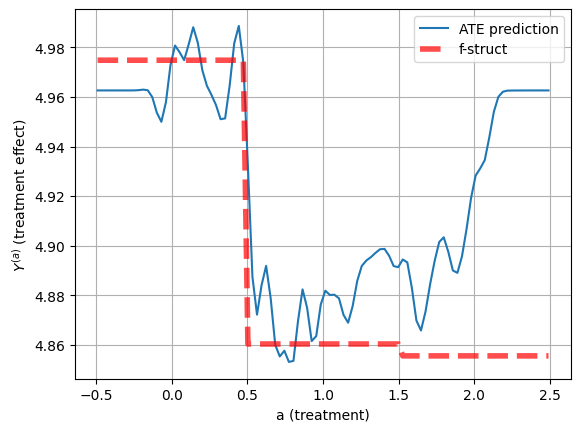

In [6]:
model.fit((A_transformed, W_transformed, Z_transformed), Y_transformed)
do_A_size = do_A.shape[0]
do_A_transformed = (A_transformer.transform(do_A)).reshape(do_A_size, -1)
f_struct_pred_transformed = model.predict(do_A_transformed)
f_struct_pred = Y_transformer.inverse_transform(f_struct_pred_transformed.reshape(do_A_size, -1)).reshape(do_A_size, -1)

structured_pred_mse = (np.mean((f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1)) ** 2))
structured_pred_mae = (np.mean(np.abs(f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1))))
print("Structured function test set MSE: {}".format(structured_pred_mse))
print("Structured function test set MAE: {}".format(structured_pred_mae))


plt.plot(do_A, f_struct_pred, label = "ATE prediction")
plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha = 0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()
plt.show()